**IMPORT LIBRARIES**

In [1]:
# Basic libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Handling imbalance
from imblearn.over_sampling import SMOTE

**LOAD DATASET**

In [2]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


**DATA EXPLORATION (EDA)**

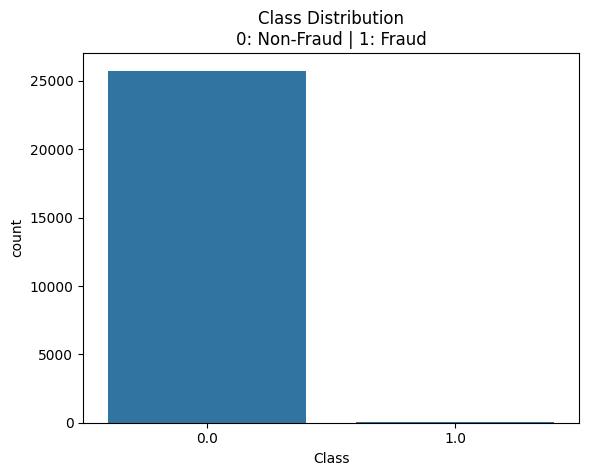

Fraudulent Transactions: 0.3406%


In [3]:
# Class distribution
sns.countplot(x='Class', data=df)
plt.title('Class Distribution\n0: Non-Fraud | 1: Fraud')
plt.show()

fraud_percentage = df['Class'].value_counts(normalize=True)[1] * 100
print(f"Fraudulent Transactions: {fraud_percentage:.4f}%")

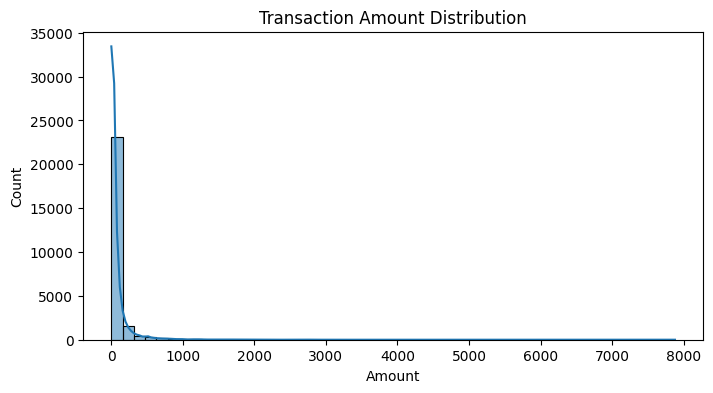

In [4]:
plt.figure(figsize=(8,4))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.show()

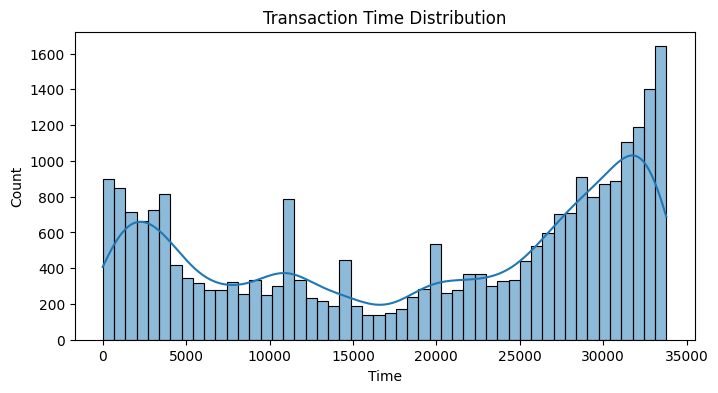

In [5]:
plt.figure(figsize=(8,4))
sns.histplot(df['Time'], bins=50, kde=True)
plt.title('Transaction Time Distribution')
plt.show()

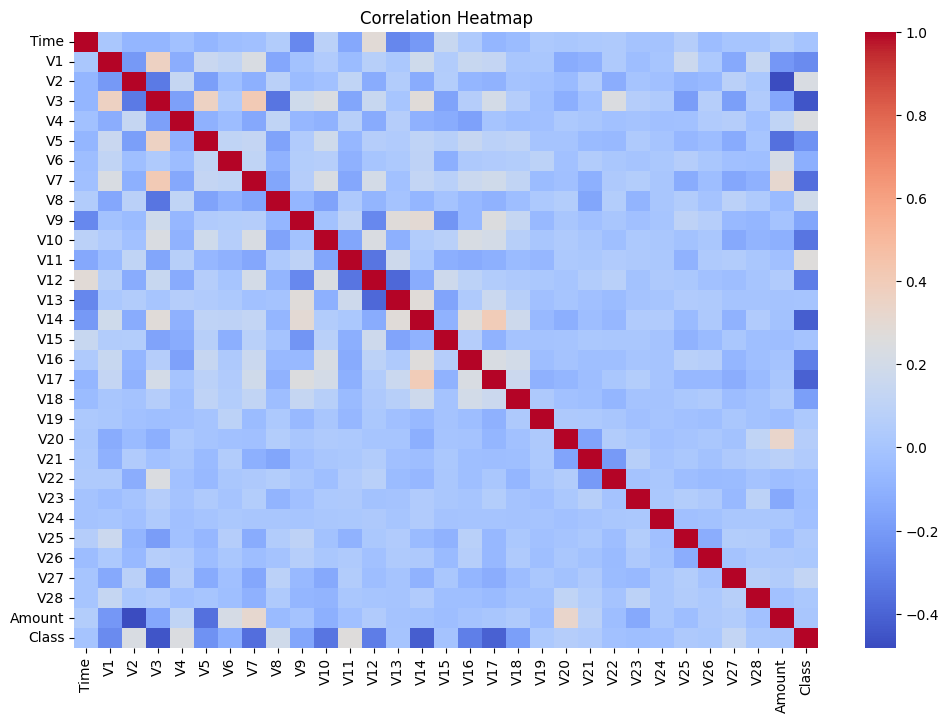

In [6]:
plt.figure(figsize=(12,8))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

**DATA PREPROCESSING**

In [7]:
scaler = StandardScaler()

df['Amount_Scaled'] = scaler.fit_transform(df[['Amount']])
df['Time_Scaled'] = scaler.fit_transform(df[['Time']])

In [8]:
df = df.drop(['Amount', 'Time'], axis=1)


**TRAIN-TEST SPLIT**

In [9]:
# Drop rows with NaN in the 'Class' column
df.dropna(subset=['Class'], inplace=True)

X = df.drop('Class', axis=1)
y = df['Class']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, k_neighbors=2) # Reduced k_neighbors
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original dataset shape:", y_train.value_counts())
print("Resampled dataset shape:", y_train_resampled.value_counts())
print(f"SMOTE k_neighbors: {smote.k_neighbors}") # Added print to show k_neighbors

Original dataset shape: Class
0.0    20599
1.0       70
Name: count, dtype: int64
Resampled dataset shape: Class
0.0    20599
1.0    20599
Name: count, dtype: int64
SMOTE k_neighbors: 2


**MODEL TRAINING**

In [12]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_resampled, y_train_resampled)

y_pred_log = log_reg.predict(X_test)

In [13]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_resampled, y_train_resampled)

y_pred_rf = rf_clf.predict(X_test)

In [14]:
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train_resampled, y_train_resampled)

y_pred_xgb = xgb_clf.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:29:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [15]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"=== {model_name} ===")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("\n")

In [16]:
evaluate_model(y_test, y_pred_log, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")

=== Logistic Regression ===
Confusion Matrix:
 [[5093   57]
 [   0   18]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      5150
         1.0       0.24      1.00      0.39        18

    accuracy                           0.99      5168
   macro avg       0.62      0.99      0.69      5168
weighted avg       1.00      0.99      0.99      5168



=== Random Forest ===
Confusion Matrix:
 [[5148    2]
 [   1   17]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5150
         1.0       0.89      0.94      0.92        18

    accuracy                           1.00      5168
   macro avg       0.95      0.97      0.96      5168
weighted avg       1.00      1.00      1.00      5168



=== XGBoost ===
Confusion Matrix:
 [[5145    5]
 [   1   17]]
Classification Report:
               precision    recall  f1-score   support

         0.

INPUT

In [19]:
def predict_transaction(model, input_data):
  input_data_2d = np.array(input_data).reshape(1, -1)
  prediction = model.predict(input_data_2d)
  return prediction[0]
sample_input = X_test.iloc[0].tolist()
result = predict_transaction(rf_clf, sample_input)
print("Prediction Result:", result)

Prediction Result: 0.0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
